In [3]:
from utils import *
import re
from pprint import pprint
from nltk.corpus import stopwords

all_data = get_data_from_db()
all_data = all_data[(all_data["labels"]== "PO") | (all_data["labels"]== "NG")]

num_remover = NumRemover()
word_remover = WordRemover(stopwords.words('portuguese'))
all_data = num_remover.fit_transform(all_data)
all_data = word_remover.fit_transform(all_data)

neg_data = all_data[all_data["labels"] == "NG"]
pos_data = all_data[all_data["labels"] == "PO"]

ratio = 0.7
neg_train = neg_data.iloc[0:round(ratio*neg_data.shape[0]), :]
pos_train = pos_data.iloc[0:round(ratio*pos_data.shape[0]), :]

neg_test = neg_data.iloc[round(ratio*neg_data.shape[0]): , :]
pos_test = pos_data.iloc[round(ratio*neg_data.shape[0]): , :]

stopwords_pt = stopwords.words("portuguese")

# Vocabulários

In [4]:
from nltk import FreqDist
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer

vocab_neg = set(' '.join(neg_train["texts"].tolist()).split())
vocab_pos = set(' '.join(pos_train["texts"].tolist()).split())

print("Dimensão vocabulario negativo: " + str(len(vocab_neg)))
print("Dimensão vocabulario positivo: " + str(len(vocab_pos)))

Dimensão vocabulario negativo: 2687
Dimensão vocabulario positivo: 2326


In [5]:
# Verificar interseção dos vocabulários
intersect = vocab_neg.intersection(vocab_pos)
vocab_neg = vocab_neg.difference(intersect)
vocab_pos = vocab_pos.difference(intersect)

lexicon = list(vocab_neg.union(vocab_pos))

In [23]:
from sklearn.naive_bayes  import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

features = FeatureUnion([
                    ("bigram", CountVectorizer(ngram_range=(2,2), stop_words= stopwords_pt, binary= True)),
                    ("lexicon_vector", CountVectorizer(vocabulary= lexicon))
                    ])

print("MultinomialNB")
run_cross_validation(all_data, features, MultinomialNB(), n_folds=5)

print("\n\nSVM")
run_cross_validation(all_data, features, SVC(C=316), n_folds=5)

MultinomialNB
Cross Validation:
Fold  0  - Acuracia:  0.822695035461
Fold  1  - Acuracia:  0.778571428571
Fold  2  - Acuracia:  0.807142857143
Fold  3  - Acuracia:  0.785714285714
Fold  4  - Acuracia:  0.807142857143

Accuracia media:  0.800253292806
Desvio padrão:  0.0160003123144


SVM
Cross Validation:
Fold  0  - Acuracia:  0.723404255319
Fold  1  - Acuracia:  0.742857142857
Fold  2  - Acuracia:  0.785714285714
Fold  3  - Acuracia:  0.742857142857
Fold  4  - Acuracia:  0.707142857143

Accuracia media:  0.740395136778
Desvio padrão:  0.0263072323206


In [10]:
from utils import *
from sklearn.naive_bayes  import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from nltk.corpus import stopwords
from nltk import FreqDist

from sklearn.preprocessing import normalize


import numpy as np
import seaborn as sns
import nltk

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

all_data = get_data_from_db()
pos_data = get_data_from_db(sentiment="PO")
neg_data = get_data_from_db(sentiment="NG")

vectorizer_void = CountVectorizer(ngram_range=(1,1), stop_words= stopwords.words("portuguese"), vocabulary = lexicon)

/home/caiomagno/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


<IPython.core.display.Javascript object>


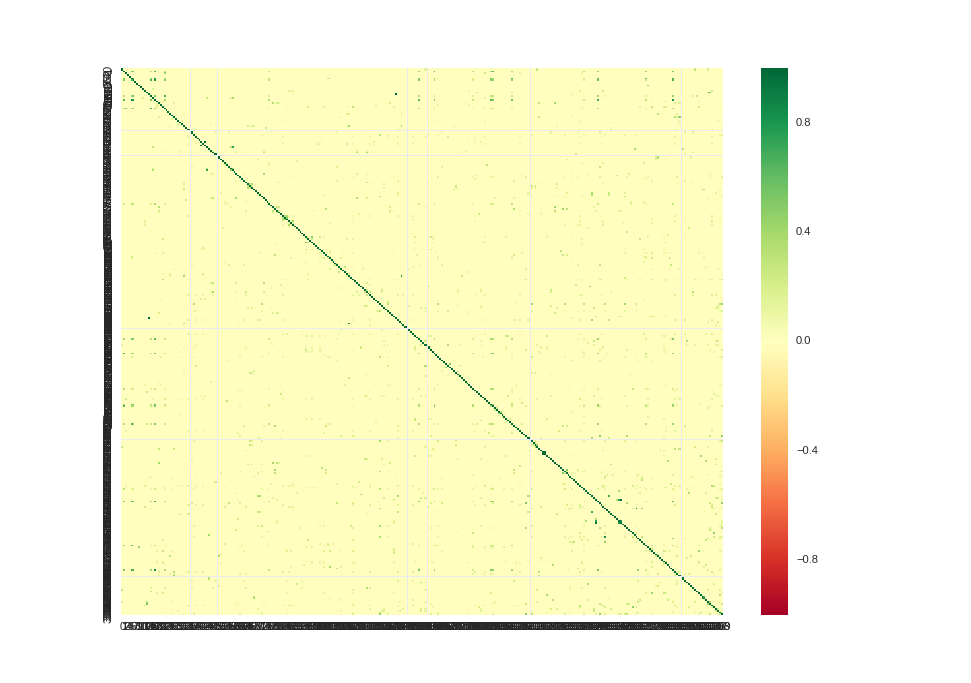

In [13]:
# Utilizando o léxico de cláudia freitas

pos_matrix = vectorizer_void.fit_transform(pos_data["texts"])
neg_matrix = vectorizer_void.fit_transform(neg_data["texts"])
all_matrix = vectorizer_void.fit_transform(all_data["texts"])

pos_matrix = normalize(pos_matrix.toarray())

pos_corr = np.corrcoef(pos_matrix)

sns.heatmap(pos_corr, cmap='RdYlGn')